In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from EOF import EOF
import datetime 

In [2]:
pr_start = 0
pr_leap = 10
pr_to = 10
total_pr = (pr_to - pr_start) / pr_leap

start = 9900
end   = 10000
internal_day = 100
total_day = int((end -start)/internal_day) * internal_day

total_file = int((end - start) / internal_day)




print("done")


done


In [3]:
### read variables ###
u_file       = h5py.File("PR0_50_0_20000day_u.h5", "r")
w_file       = h5py.File("PR0_50_0_20000day_w.h5", "r")

qv_file      = h5py.File("PR0_50_0_20000day_qv.h5", "r")
qv_diff_file = h5py.File("PR0_50_0_20000day_qv_diff.h5", "r")
p_file       = h5py.File("PR0_50_0_20000day_p.h5", "r")
ps_file      = h5py.File("PR0_50_0_20000day_ps.h5", "r")
p_half_file  = h5py.File("PR0_50_0_20000day_p_half.h5", "r")

z_full_file  = h5py.File("PR0_50_0_20000day_z_full.h5", "r")



print("---1---")
u_origin       = np.asarray(u_file["u"][:,int(start):end,:,:,:])
print("---2---")
qv_diff_origin = np.asarray(qv_diff_file["qv_diff"][:,int(start):end,:,:,:])
print("---3---")
p_origin       = np.asarray(p_file["p"][:,int(start):end,:,:,:])
print("---4---")
ps_origin      = np.asarray(ps_file["ps"][:,int(start):end,:,:,:])
print("---5---")
p_half_origin  = np.asarray(p_half_file["p_half"][:,int(start):end,:,:,:])
print("---6---")

w_origin       = np.asarray(w_file["w"][:,int(start):end,:,:,:])
z_full_origin       = np.asarray(z_full_file["z_full"][:,int(start):end,:,:,:])


print("done")

u_file.close()
qv_file.close()
qv_diff_file.close()
p_file.close()
ps_file.close()
p_half_file.close()
w_file.close()
z_full_file.close()





---1---
---2---
---3---
---4---
---5---
---6---
done


In [4]:
v_file       = h5py.File("PR0_50_0_20000day_v.h5", "r")
v_origin       = np.asarray(v_file["v"][:,int(start):end,:,:,:])
t_file       = h5py.File("PR0_50_0_20000day_t.h5", "r")
t_origin       = np.asarray(t_file["t"][:,int(start):end,:,:,:])

v_file.close()
t_file.close()

print("done")

done


In [5]:
class TEM:
    """
    Step 1. interpolation z -> z_new
    Step 2. Calculate v* and w*
    Step 3. Smooth v* and w* (there is singular point)
    Step 4. Calculate TEM streamfunction
    """

    ### Step 1. 
    def __init__(
        self, 
        input_v, 
        input_omega, 
        input_p, 
        input_ps, 
        input_t,
        input_z,
        single_day):

        Rd    = 287
        cp    = 1004
        g     = 9.81
        self.v = input_v
        self.omega = input_omega
        self.p  = input_p
        self.ps = input_ps
        self.t = input_t
        self.z = input_z
        
        # # lat, lev
        if single_day: 
            self.sigma_mean      = np.nanmean(self.p/self.ps, axis=(2))
        else:
            self.sigma_mean      = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz     = np.nanmean(self.sigma_mean, axis=1)
        self.y               = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)

        self.rho = self.p / self.ps
        self.w   = -self.omega / self.rho / g

        self.single_day = single_day
        # int
        if single_day: 
            # self.day = self.z.shape[0]
            self.day = int(1)
            self.lev = self.z.shape[0]
            self.lat = self.z.shape[1]
            self.lon = self.z.shape[2]
        else: 
            self.day = self.z.shape[0]
            self.lev = self.z.shape[1]
            self.lat = self.z.shape[2]
            self.lon = self.z.shape[3]


    
        # sigma = self.p / self.ps
        # sigma_mean  = np.nanmean(sigma, axis=(0,3))
        # sigma_onlyz = np.nanmean(self.sigma_mean, axis=1)

        ###
        self.theta = self.t * (self.ps / self.p)**(Rd/cp)
    

    def _interpolation(self):
        self.z_new     = np.zeros(((( self.day, int(self.lev+2), self.lat, self.lon ))))
        self.theta_new = np.zeros(((( self.day, int(self.lev+2), self.lat, self.lon ))))

        if self.single_day:
            for i in range(self.day):
                for j in range(self.lat):
                      for k in range(self.lon):
                        fe                  = interp1d(np.linspace(0,self.lev,self.lev),self.z[:,j,k],  fill_value='extrapolate')
                        self.z_new[i,:,j,k] = fe(np.linspace(-1,21,22))
                        fe                  = interp1d(np.linspace(0,self.lev,self.lev),self.theta[:,j,k],  fill_value='extrapolate')
                        self.theta_new[i,:,j,k] = fe(np.linspace(-1,21,22))
                if i % 100 == 0:
                    print(f"int({i})")
            # print("done")
        else:
            for i in range(self.day):
                for j in range(self.lat):
                      for k in range(self.lon):
                        fe                  = interp1d(np.linspace(0,self.lev,self.lev),self.z[i,:,j,k],  fill_value='extrapolate')
                        self.z_new[i,:,j,k] = fe(np.linspace(-1,21,22))
                        fe                  = interp1d(np.linspace(0,self.lev,self.lev),self.theta[i,:,j,k],  fill_value='extrapolate')
                        self.theta_new[i,:,j,k] = fe(np.linspace(-1,21,22))
                if i % 100 == 0:
                    print(f"int({i})")
            # print("done")

    # def _neighbor_idx(self):
    def _neighbor_idx(self, var, length):
        import copy
        idx = np.dstack(np.unravel_index(np.argsort(var.ravel()), var.shape))
        
        var_new = copy.deepcopy(var)
        
        for i in range(length):
            if idx[0,i,0] <= 18 and idx[0,i,0] >=1 and idx[0,i,1] <= 62 and idx[0,i,1] >=1:
                var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0]-1, idx[0,i,1]] + var[idx[0,i,0]+1, idx[0,i,1]] + var[idx[0,i,0], idx[0,i,1]-1] + var[idx[0,i,0], idx[0,i,1]+1]) / 4 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
            
            ### four line except the four corner
            elif idx[0,i,1] == 0 and idx[0,i,0] <= 18 and idx[0,i,0] >= 1:
                # if idx[0,i,0] == 19:
                    # var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0]-1, idx[0,i,1]] + var[idx[0,i,0], idx[0,i,1]+1]) / 2 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
                
                if var[idx[0,i,0]-1, idx[0,i,1]] < 1000 and var[idx[0,i,0]+1, idx[0,i,1]] < 1000 and var[idx[0,i,0], idx[0,i,1]+1] < 1000:
                    # print("hi1")
                    var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0]-1, idx[0,i,1]] + var[idx[0,i,0]+1, idx[0,i,1]] + var[idx[0,i,0], idx[0,i,1]+1]) / 3 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
                
                elif var[idx[0,i,0]-1, idx[0,i,1]] > 1000 and var[idx[0,i,0]+1, idx[0,i,1]] < 1000 and var[idx[0,i,0], idx[0,i,1]+1] < 1000:
                    # print("hi2")
                    var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0]+1, idx[0,i,1]] + var[idx[0,i,0], idx[0,i,1]+1]) / 2 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
                
                elif var[idx[0,i,0]-1, idx[0,i,1]] > 1000 and var[idx[0,i,0]+1, idx[0,i,1]] > 1000 and var[idx[0,i,0], idx[0,i,1]+1] < 1000:
                    # print("hi3")
                    var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,1]+1])  # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
    
                elif var[idx[0,i,0]-1, idx[0,i,1]] > 1000 and var[idx[0,i,0]+1, idx[0,i,1]] > 1000 and var[idx[0,i,0], idx[0,i,1]+1] > 1000:
                    # print("hi4")
                    var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0], idx[0,i,1]+2])  # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
    
                
            elif idx[0,i,1] == 63 and idx[0,i,0] <= 18 and idx[0,i,0] >= 1:
                var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0]-1, idx[0,i,1]] + var[idx[0,i,0]+1, idx[0,i,1]] + var[idx[0,i,0], idx[0,i,1]-1]) / 3 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
            
            elif idx[0,i,0] == 0 and idx[0,i,1] <= 62 and idx[0,i,0] >= 1:
                var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0], idx[0,i,1]-1] + var[idx[0,i,0], idx[0,i,1]+1] + var[idx[0,i,0]+1, idx[0,i,1]]) / 3 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
            
    
            elif idx[0,i,0] == 19 and idx[0,i,1] <= 62 and idx[0,i,1] >= 1:
                var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0], idx[0,i,1]-1] + var[idx[0,i,0], idx[0,i,1]+1] + var[idx[0,i,0]-1, idx[0,i,1]]) / 3 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))

            ### four corner ###
            elif idx[0,i,0] == 0  and idx[0,i,1] == 0:
                var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0], idx[0,i,1]+1] + var[idx[0,i,0]+1, idx[0,i,1]]) / 2 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))

            elif idx[0,i,0] == 19 and idx[0,i,1] == 0:
                var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0]-1, idx[0,i,1]]  + var[idx[0,i,0], idx[0,i,1]+1]) / 2 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))

            elif idx[0,i,0] == 0 and idx[0,i,1] == 63:
                var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0]+1, idx[0,i,1]] + var[idx[0,i,0], idx[0,i,1]-1] ) / 2 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))

            elif idx[0,i,0] == 19 and idx[0,i,1] == 63:
                var_new[idx[0,i,0], idx[0,i,1]]  = (var[idx[0,i,0]-1, idx[0,i,1]] + var[idx[0,i,0], idx[0,i,1]-1]) / 2 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
        
            
        
        # ===============================================================    
        for i in range(length):
            if idx[0,-i,0] <= 18 and idx[0,-i,0] >=1 and idx[0,-i,1] <= 62 and idx[0,-i,1] >=1:
                var_new[idx[0,-i,0], idx[0,-i,1]]  = (var[idx[0,-i,0]-1, idx[0,-i,1]] + var[idx[0,-i,0]+1, idx[0,-i,1]] + var[idx[0,-i,0], idx[0,-i,1]-1] + var[idx[0,-i,0], idx[0,-i,1]+1]) / 4 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
                

            ### four line except the four corner
            elif idx[0,-i,1] == 0 and idx[0,-i,0] <= 18 and idx[0,-i,0] >= 1:
                var_new[idx[0,-i,0], idx[0,-i,1]]  = (var[idx[0,-i,0]-1, idx[0,-i,1]] + var[idx[0,-i,0]+1, idx[0,-i,1]] + var[idx[0,-i,0], idx[0,-i,1]+1]) / 3 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
                
            
            elif idx[0,-i,1] == 63 and idx[0,-i,0] <= 18 and idx[0,-i,0] >= 1:
                var_new[idx[0,-i,0], idx[0,-i,1]]  = (var[idx[0,-i,0]-1, idx[0,-i,1]] + var[idx[0,-i,0]+1, idx[0,-i,1]] + var[idx[0,-i,0], idx[0,-i,1]-1]) / 3 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
                
    
            elif idx[0,-i,0] == 0 and idx[0,-i,1] <= 62 and idx[0,-i,0] >= 1:
                var_new[idx[0,-i,0], idx[0,-i,1]]  = (var[idx[0,-i,0], idx[0,-i,1]-1] + var[idx[0,-i,0], idx[0,-i,1]+1] + var[idx[0,-i,0]+1, idx[0,-i,1]]) / 3 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
                
    
            elif idx[0,-i,0] == 19 and idx[0,-i,1] <= 62 and idx[0,-i,1] >= 1:
                var_new[idx[0,-i,0], idx[0,-i,1]]  = (var[idx[0,-i,0], idx[0,-i,1]-1] + var[idx[0,-i,0], idx[0,-i,1]+1] + var[idx[0,-i,0]-1, idx[0,-i,1]]) / 3 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))

            ### four corner ###
            elif idx[0,-i,0] == 0  and idx[0,-i,1] == 0:
                var_new[idx[0,-i,0], idx[0,-i,1]]  = (var[idx[0,-i,0], idx[0,-i,1]+1] + var[idx[0,-i,0]+1, idx[0,-i,1]]) / 2 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))

            elif idx[0,-i,0] == 19 and idx[0,-i,1] == 0:
                var_new[idx[0,-i,0], idx[0,-i,1]]  = (var[idx[0,-i,0]-1, idx[0,-i,1]]  + var[idx[0,-i,0], idx[0,-i,1]+1]) / 2 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))

            elif idx[0,-i,0] == 0 and idx[0,-i,1] == 63:
                var_new[idx[0,-i,0], idx[0,-i,1]]  = (var[idx[0,-i,0]+1, idx[0,-i,1]] + var[idx[0,-i,0], idx[0,-i,1]-1] ) / 2 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))

            elif idx[0,-i,0] == 19 and idx[0,-i,1] == 63:
                var_new[idx[0,-i,0], idx[0,-i,1]]  = (var[idx[0,-i,0]-1, idx[0,-i,1]] + var[idx[0,-i,0], idx[0,-i,1]-1]) / 2 # fe(np.linspace(idx[0,i,0]-1,idx[0,i,0]+1,2))
        




        
        return var_new
              
    def _vTEM_wTEM(self):

        g     = 9.81
        H     = 6800
        a     = 6.37122e6

        # THzm   = np.nanmean(theta, axis=(3))
        if self.single_day:
            THzmtm = np.nanmean(self.theta, axis=(2)) 
        else:
            THzmtm = np.nanmean(self.theta, axis=(0,3)) 
        
        dTHdz  = np.zeros((20,64)) ############ 
        z_test = 6800 * np.log(self.ps/self.p)
        if self.single_day:
            z_mean = np.nanmean(self.z, axis=(1,2))
        else:
            z_mean = np.nanmean(self.z, axis=(0,2,3))
        for i in range(1,19):
            dTHdz[i,:] = (THzmtm[i+1,:] - THzmtm[i-1,:]) / (z_mean[i+1] - z_mean[i-1]) #########
    
        THzmtm_new = np.nanmean(self.theta_new, axis=(0,3)) 
        z_mean_new = np.nanmean(self.z_new, axis=(0,2,3))
        
    
        dTHdz[0,:]  = (THzmtm_new[2,:]  - THzmtm_new[0,:])  /  (z_mean_new[2]  - z_mean_new[0])
        dTHdz[-1,:] = (THzmtm_new[-1,:] - THzmtm_new[-3,:]) /  (z_mean_new[-1] - z_mean_new[-3])
        
        dTHdz[dTHdz == 0] = np.nan # just in case divided by zero 
        

        # Wza = np.zeros(self.v.shape)

        if self.single_day:
            Vza = np.zeros(self.v.shape)
            THETAza = np.zeros(self.v.shape)
            Vzm = np.nanmean(self.v, axis=2)
            THzm = np.nanmean(self.theta, axis=2)
            for i in range(0,128):
                Vza[:,:,i]     = self.v[:,:,i] - Vzm
                THETAza[:,:,i] = self.theta[:,:,i] - THzm
        else:
            Vza = np.zeros(self.v.shape)
            THETAza = np.zeros(self.v.shape)
            Vzm = np.nanmean(self.v, axis=3)
            THzm = np.nanmean(self.theta, axis=3)
            for i in range(0,128):
                Vza[:,:,:,i]     = self.v[:,:,:,i] - Vzm
                THETAza[:,:,:,i] = self.theta[:,:,:,i] - THzm
            
        VTHETA  = Vza * THETAza
        if self.single_day:
            VTHzm   = np.nanmean(VTHETA, axis=2)   ### mean lon
            VTHzmtm = VTHzm # np.nanmean(VTHzm,  axis=0)   ### mean time

            Wzm = np.nanmean(self.w, axis=2)
            self.Wzmtm = Wzm

            Vzm = np.nanmean(self.v, axis=(2)) #########
            Vzmtm = Vzm

            rho_0_zmtm = np.nanmean(self.rho, axis=(0,2))
        
        else:
            VTHzm   = np.nanmean(VTHETA, axis=3)   ### mean lon
            VTHzmtm = np.nanmean(VTHzm,  axis=0)   ### mean time

            Wzm = np.nanmean(self.w, axis=3)
            self.Wzmtm = np.nanmean(Wzm, axis=0)

            Vzm = np.nanmean(self.v, axis=(3)) #########
            Vzmtm = np.nanmean(Vzm, axis=0)

            rho_0_zmtm = np.nanmean(self.rho, axis=(0,3))
            
        # print("---3---")

        
        # Wzm = np.nanmean(self.w, axis=3)
        # Wzmtm = np.nanmean(Wzm, axis=0)
        # Vzm = np.nanmean(self.v, axis=(3)) #########
        # Vzmtm = np.nanmean(Vzm, axis=0)
        
        # phi
        phi = np.broadcast_to(np.deg2rad(self.y).reshape(1,64),(20,64)) # Get latitude in radians
        lat_new = np.broadcast_to(self.y.reshape(1,64),(20,64)) # Get latitude in radians
        
        cphi  = np.cos(phi) 
        self.acphi = a * cphi
    
        # calculate vTEM = v - 1/rho0 d/dz(rho0 v'TH'/THz)    
        vTEM_temp  = rho_0_zmtm * VTHzmtm / dTHdz ############################################
        vTEM_tempdz = np.zeros((20,64))
        for i in range(1,19):
            vTEM_tempdz[i,:] = (vTEM_temp[i+1,:] - vTEM_temp[i-1,:]) /  (z_mean[i+1] - z_mean[i-1])
    
        vTEM_temp_new = np.zeros((22, vTEM_temp.shape[1]))
        for j in range(vTEM_temp.shape[1]):
                fe            = interp1d(np.linspace(0,20,20),vTEM_temp[:,j],  fill_value='extrapolate')
                vTEM_temp_new[:,j] = fe(np.linspace(-1,21,22))
            
        vTEM_tempdz[0,:]  = (vTEM_temp_new[2,:]  - vTEM_temp_new[0,:]) /  (z_mean_new[2]  - z_mean_new[0])
        vTEM_tempdz[-1,:] = (vTEM_temp_new[-1,:] - vTEM_temp_new[-3,:]) / (z_mean_new[-1] - z_mean_new[-3])
    
        biggest = 10
        vTEM_tempdz_smooth = self._neighbor_idx(vTEM_tempdz, biggest)
        
        # print("---4---")
        if self.single_day:
            vTEM1 = np.nanmean(self.v, axis=(0,2)) # Vzmtm 
            # print(self.rho)
            vTEM2 = (1/np.nanmean(self.rho, axis=(0,2))) * vTEM_tempdz_smooth
        else:
            vTEM1 = np.nanmean(self.v, axis=(0,3)) # Vzmtm 
            vTEM2 = (1/np.nanmean(self.rho, axis=(0,3))) * vTEM_tempdz_smooth
        vTEM  = vTEM1 - vTEM2
        #######################################################################################################
        # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
        wTEM_temp =  cphi * VTHzmtm / dTHdz
        wTEM_tempdphi = np.zeros((20,64))
        for i in range(1,63):
            wTEM_tempdphi[:,i] = (wTEM_temp[:,i+1] - wTEM_temp[:,i-1]) / (phi[:,i+1] - phi[:,i-1])
    
        wTEM_temp_new = np.zeros((20, 64+2))
        phi_new  = np.zeros((20, 64+2))
        phi_new2 = np.deg2rad(np.linspace(-90,90,66))
        
        for i in range(vTEM_temp.shape[0]):
                fe            = interp1d(np.linspace(0,self.lat,self.lat),wTEM_temp[i,:],  fill_value='extrapolate')
                wTEM_temp_new[i,:] = fe(np.linspace(-1,65,66))
                fe           = interp1d(np.linspace(0,64,64),phi[i,:],  fill_value='extrapolate')
                phi_new[i,:] = fe(np.linspace(-1,65,66))
            
        wTEM_tempdphi[:,0]  = (wTEM_temp_new[:,2]  - wTEM_temp_new[:,0])  / (phi_new[:,2] - phi_new[:,0])
        wTEM_tempdphi[:,-1] = (wTEM_temp_new[:,-1] - wTEM_temp_new[:,-3]) / (phi_new[:,-1] - phi_new[:,-3])
    
        biggest = 30
        wTEM_tempdphi_smooth = self._neighbor_idx(wTEM_tempdphi, biggest)
        
        # print("---5---")
        
        wTEM1 = self.Wzmtm ##################
        self.acphi[self.acphi ==0] = np.nan
        # acphi[acphi < 0.001] = np.nan
        wTEM2 = (wTEM_tempdphi_smooth) / self.acphi
        wTEM2[wTEM2 < -1E5] = np.nan
        wTEM2[wTEM2 > 1E5]  = np.nan
        
        wTEM = wTEM1 + wTEM2
        
        return vTEM, wTEM

    def _plot_vTEM_wTEM(self, vTEM, wTEM):
        fig, ax = plt.subplots(2, figsize=(8,6), dpi=100.)
        CS = ax[0].contourf(self.yy, self.sigma_mean2, wTEM, levels=np.linspace(-0.005,0.005,11), cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[0])
        ax[0].set_ylim([1,0])
        ax[0].set_title("$w^*$")
        # plt.show()
        
        # plt.figure()
        CS = ax[1].contourf(yy, sigma_mean2, vTEM, levels=21, cmap="RdBu_r", extend="both")
        plt.colorbar(CS, ax=ax[1])
        ax[1].set_ylim([1,0])
        ax[1].set_title("$v^*$")
        plt.show()

    def _cal_psi(self, vTEM):
        psi_w1 = self.Wzmtm #np.nanmean(w , axis=(0,3))
        psi_w2 = self.Wzmtm #np.nanmean(w , axis=(0,3))
        """
        psi_w1[:,0] = 0
        for ilat in range(1,63):        
            dlat = phi[:,ilat] - phi[:,ilat-1]       
            psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * rho_0_mean[:,ilat] * acphi[:,ilat] * wTEM[:,ilat])
    
        psi_w2[:,64-1] = 0
        for jlat in range(1,64-1):        
            ilat = 64 - 1 - jlat
            dlat = phi[:,ilat] - phi[:,ilat+1]           
            psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * rho_0_mean[:,ilat] * acphi[:,ilat] * wTEM[:,ilat])
        psi_w = 0.5*(psi_w1 + psi_w2)
        
        
        """
        p_mean = np.nanmean(p_origin[0], axis=(0,3)) 
        psi_w1[0,:] = 0
        g = 9.81
        for ilev in range(1,19):        
            dlev = p_mean[ilev+1,:] - p_mean[ilev-1,:]       
            psi_w1[ilev,:] =  psi_w1[ilev-1,:] - 2*np.pi/g*self.acphi[ilev,:] * (dlev  * vTEM[ilev,:])
        psi_w = psi_w1
        return psi_w

    def _plot_psi(self, psi_w):
        fig, ax = plt.subplots(2, figsize=(10,8), dpi=150.)
        CS = ax[0].contour(yy,sigma_mean2, psi_w / 10**9, levels=21, colors='k') # 
        plt.clabel(CS, fontsize=8)
        ax[0].set_ylim([1,0])
        ax[0].set_title("TEM ( 10^9 kg $m^{-1}$ $s^{-1}$)", fontsize=16)
        # plt.show()
        
        # plt.figure(figsize=(8,6), dpi=100.)
        CS = ax[1].contourf(yy,sigma_mean2, psi_w , levels=21, cmap="RdBu_r", extend="both") #         
        plt.colorbar(CS, ax=ax[1], fraction=0.046, pad=0.04)
        ax[1].set_ylim([1,0])
        ax[1].set_title("TEM ( 10^9 kg $m^{-1}$ $s^{-1}$)", fontsize=16)
        
        plt.show()
        
    def get(self):
        self._interpolation()
        vTEM, wTEM = self._vTEM_wTEM()
        # self._plot_vTEM_wTEM(vTEM, wTEM)
        psi_w = self._cal_psi(vTEM)
        # self._plot_psi(psi_w)
        
        return vTEM, wTEM, psi_w

In [6]:
vTEM_all  = np.zeros(((z_full_origin.shape[1], 20, 64)))
wTEM_all  = np.zeros(((z_full_origin.shape[1], 20, 64)))
psi_w_all = np.zeros(((z_full_origin.shape[1], 20, 64)))
print(ps_origin.shape)
for i in range(z_full_origin.shape[1]):
    tem = TEM(v_origin[0,i], w_origin[0,i], p_origin[0,i], ps_origin[0,i], t_origin[0,i], z_full_origin[0,i], True)
    # tem = TEM(v_origin[0,:], w_origin[0,:], p_origin[0,:], ps_origin[0,:], t_origin[0,:], z_full_origin[0,:], False)
    vTEM, wTEM, psi_w = tem.get()
    vTEM_all[i], wTEM_all[i], psi_w_all[i] = vTEM, wTEM, psi_w

(6, 100, 20, 64, 128)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)
int(0)


0


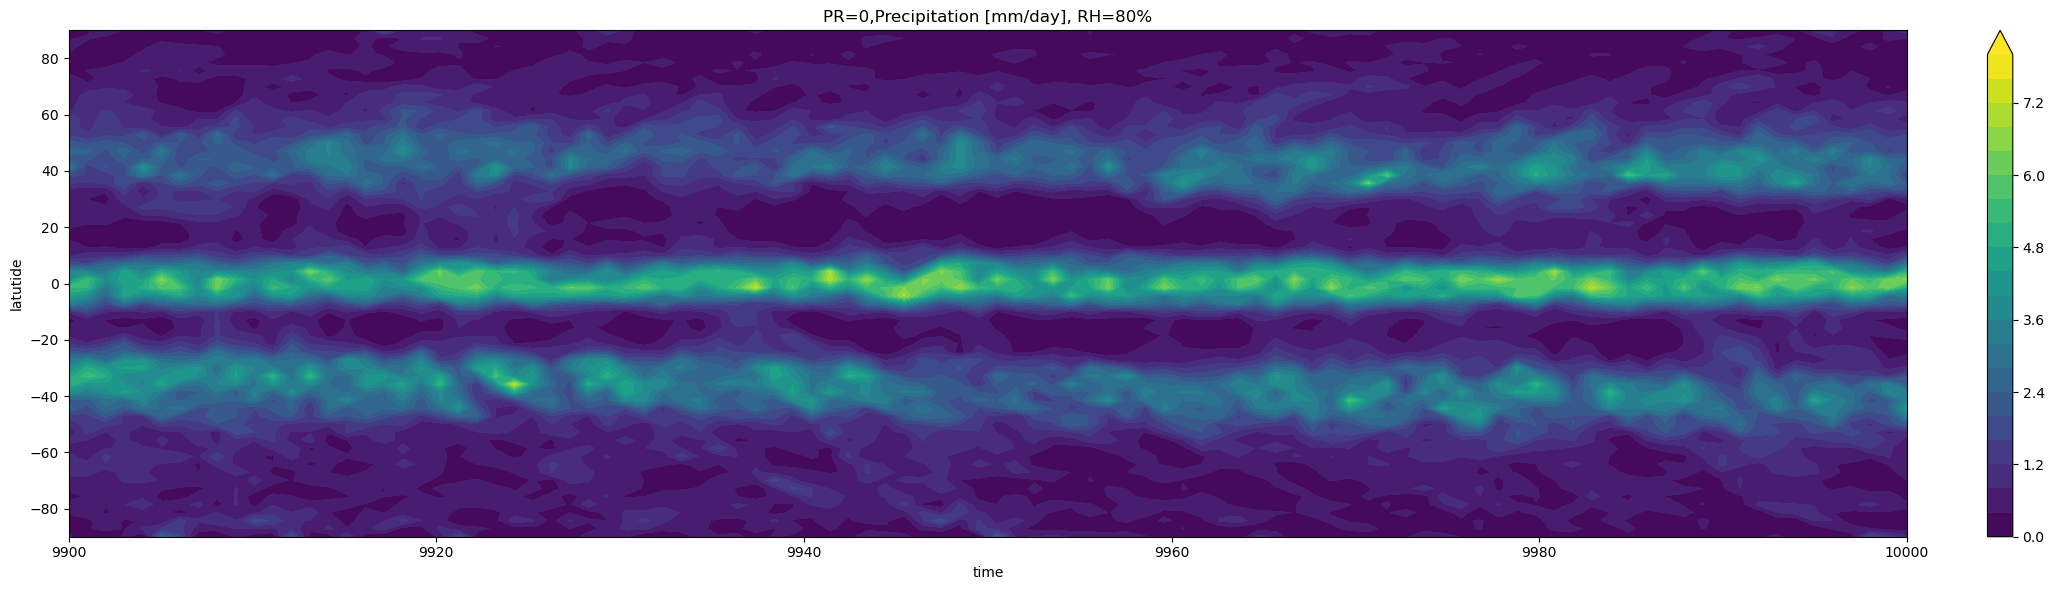

In [16]:
from Dycore import Dycore
file  = "HSt42_10_20000day/RH80_PR10_20000day_startfrom_0day_final.dat"

dycore = Dycore(file)
### fig
y = np.linspace(-90,90,64)
total_day = int(end - start)
time = np.linspace(start, end, total_day)

yy, tt = np.meshgrid(y,time)

do_check_qv = True
do_check_KE = False
do_check_t  = False

test = np.zeros(((int((pr_to - pr_start)/pr_leap), tt.shape[0], tt.shape[1])))
a = 0           
Prec_all = np.zeros(p_origin.shape)

single_pr = True
for pr in range(pr_start, pr_to, pr_leap):
    if do_check_qv:
        print(a)
        Prec_new, Prec_fulldim   = dycore.cal_pre(qv_diff_origin[a], p_half_origin[a])
        if single_pr:
            fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,6))
            CS = plt.contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,8,21), extend="max")    
            fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04)
            plt.title(f"PR={pr},Precipitation [mm/day], RH=80%")    
            plt.xlabel("time")
            plt.ylabel("latutide")
            test[a] = Prec_new
            Prec_all[a] = Prec_fulldim
        else:
            fig,ax   = plt.subplots(int((pr_to - pr_start)/pr_leap),figsize=(21,18))
            CS = ax[a].contourf(tt, yy, Prec_new[:,:] * 86400,levels=np.linspace(0,8,21), extend="max")    
            fig.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04, ax=ax[a])
            ax[a].set_title(f"PR={pr},Precipitation [mm/day], RH=80%")    
            ax[a].set_xlabel("time")
            ax[a].set_ylabel("latutide")
            test[a] = Prec_new
            Prec_all[a] = Prec_fulldim
        a += 1

if do_check_qv:
    fig.tight_layout()
    # plt.savefig("check_qv_equilibrium.png", dpi=300., bbox_inches='tight')
    plt.show()

In [17]:
print(tt.shape)

(100, 64)


[-21.42857143 -18.57142857 -15.71428571 -12.85714286 -10.
  -7.14285714  -4.28571429  -1.42857143   1.42857143   4.28571429
   7.14285714  10.          12.85714286  15.71428571  18.57142857
  21.42857143]
(100, 20, 64)
(100, 20, 64)


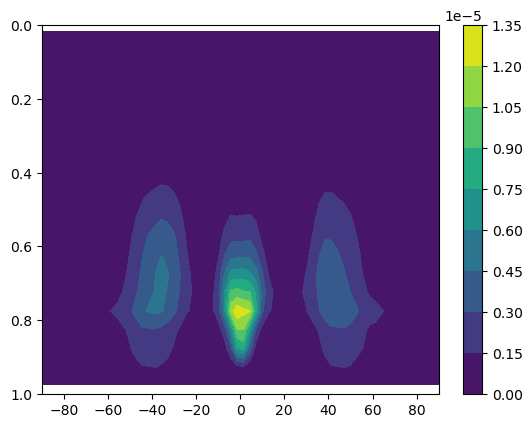

In [18]:
sigma_mean      = np.nanmean(p_origin[0]/ps_origin[0], axis=(0,3))
sigma_onlyz     = np.nanmean(sigma_mean, axis=1)
y               = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)


plt.figure()
CS = plt.contourf(yy, sigma_mean2, np.nanmean(Prec_all[0], axis=(0,3)), levels=11)
plt.colorbar(CS)
plt.ylim([1,0])
### Chose 20S ~ 20N do mean precipitation
print(y[24:40])
prec_mean = np.nanmean(Prec_all[0], axis=(0,3))
# print(Prec_all.shape)

# final = np.dot(prec_mean[:,24:40], psi_w[:,24:40].T)
Prec_zm = np.nanmean(Prec_all[0], axis=3)
# psi_w_all
print(Prec_zm.shape)
print(psi_w_all.shape)
final = np.zeros(Prec_zm.shape[0])
for i in range(final.shape[0]):
    final[i] = (np.dot(np.reshape(Prec_zm[i, :, 24:40], (20*16)),  np.reshape(psi_w_all[i, :, 24:40], (20*16))))


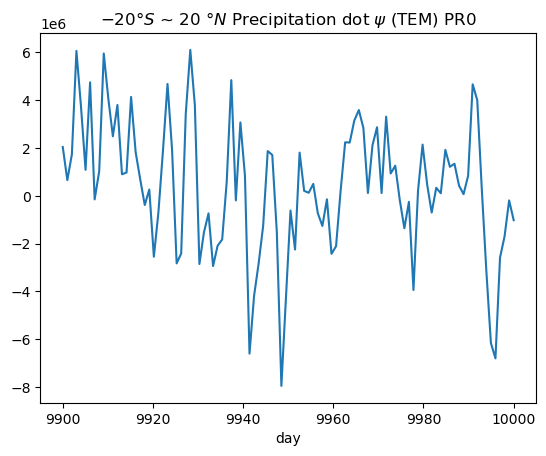

In [19]:
plt.figure()
plt.plot(time,final)
plt.title("$ -20 \degree S $ ~ 20 $\degree N$ Precipitation dot $\psi$ (TEM) PR0")
plt.xlabel("day")
plt.savefig("Prec_dot_TEM.png", dpi=300., bbox_inches='tight')
